In [1]:
%load_ext autoreload
%autoreload 2

In [94]:
import sys
sys.path.append('/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
from matplotlib import cm, colors
from matplotlib.ticker import FormatStrFormatter
import torch
import h5py
from  torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from scipy.stats import pearsonr
from scipy.special import factorial
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from fnn.evaluation import *
import fnn.models as models
from fnn.config import get_custom_cfg
from fnn.data import TestDataset, ValidationDataset
from fnn.distributions import *
from fnn.notebook.utils import *
from torchdeepretina.datas import loadexpt
from torchdeepretina.pyret_func import estfr
from torchdeepretina.utils import inspect

In [3]:
file_path = '/home/xhding/tem_stim/21-03-15/naturalscene.h5'
cells = [0,1,2,3,4,6]
t_list = [3,3,3,3,2,3]
recording = recording_stats(file_path, cells)
recording_cut = recording_stats(file_path, cells, truncate=True, t_list=t_list)
single_trial_bin = recording.single_trial_bin
single_trial_bin_cut = recording_cut.single_trial_bin

In [130]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('fc_phase2_21-03-15')
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack_FC_2/epoch_095_loss_-0.78_pearson_0.6443.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=500)
test_pc, pred, targ = pearsonr_batch_eval(model, test_data, 6, device)

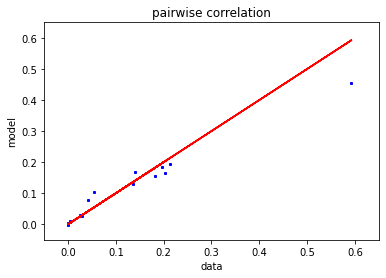

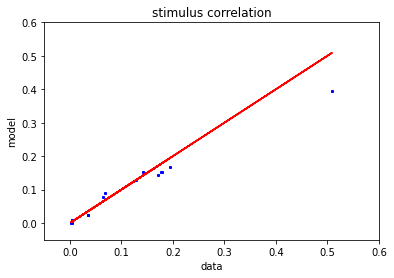

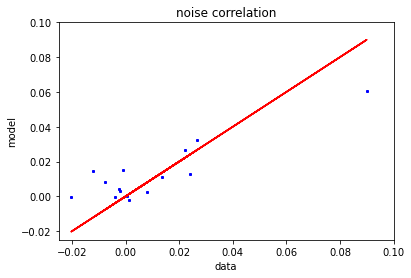

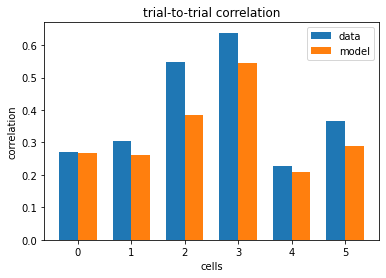

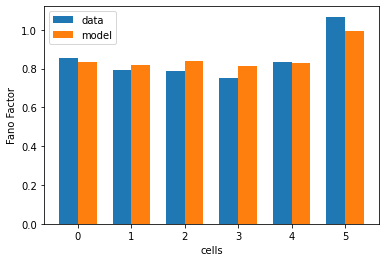

0.005567171374316402


In [58]:
binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
t_list = [3,3,3,3,2,3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0., 0., 0.1, 0.], seed=None, noise_locs=[3,4,5])
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.15, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=None, thre=1)

min_error = 10
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

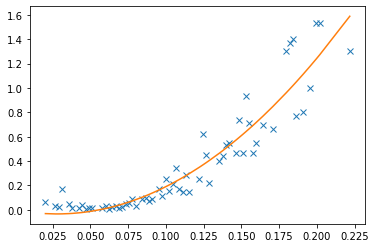

In [53]:
def poly(x,c,d):
        return c*x**2+d*x
    
cell = 2
means = []
rates = []
sigmas = []

pred_single_trial_pre[:, pred<1] = 0
for rate in np.linspace(0.25, pred_single_trial_pre.mean(0)[:, cell].max(), 100):
    mean, var, _, w = recording.stats_rate(pred_single_trial_pre.mean(0), cell=cell, rate=rate, intv=0.15)
    if var > 0:
        sigmas.append(np.sqrt(var/(w-1)))
        means.append(mean)
        rates.append(rate/100)
sigmas = np.array(sigmas)[~np.isnan(means)]
rates = np.array(rates)[~np.isnan(means)]
means = np.array(means)[~np.isnan(means)]

max_idx = np.where(means >= 0.8*means.max())[0][-1]
min_idx = np.where(rates == rates.min())[0][0]
slope = (means[max_idx] -  means[min_idx]) / (rates[max_idx] -  rates[min_idx])
means_res = means - (rates - rates[min_idx]) * slope - means[min_idx]
valid_idx = np.where(np.abs(means_res/means[max_idx]) < 0.4)

rates = rates[valid_idx]
means = means[valid_idx]
sigmas = sigmas[valid_idx]

para = curve_fit(poly, rates, means, sigma=sigmas)[0]

plt.plot(rates, means, 'x')
plt.plot(rates, [poly(rates[i], *para) for i in range(len(rates))])

In [54]:
g2_errors = []
g1_errors = []
g0_errors = []

t_list = [3,3,3,3,2,3]

for g2 in np.linspace(0., 0.2, 51):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0, 0, g2, 0], noise_locs=[3,4,5])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.15, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, thre=1)
    
    min_error = 10
    
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial)
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g2_errors.append((g2, min_error_stim, min_error))

for g1 in np.linspace(0., 0.2, 51):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0, g1, 0, 0], noise_locs=[3,4,5])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.15, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, thre=1)
    
    min_error = 10
    
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial)
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g1_errors.append((g1, min_error_stim, min_error))

for g0 in np.linspace(0, 2, 51):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [g0, 0, 0, 0], noise_locs=[3,4,5])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.15, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, thre=1)
    
    min_error = 10
    
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial)
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g0_errors.append((g0, min_error_stim, min_error))

Stimulus correlation


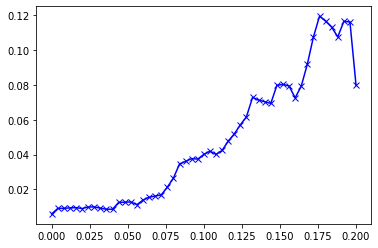

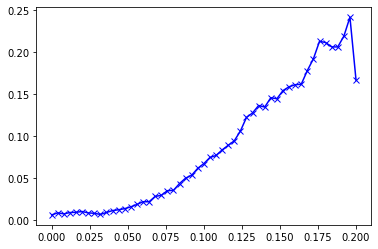

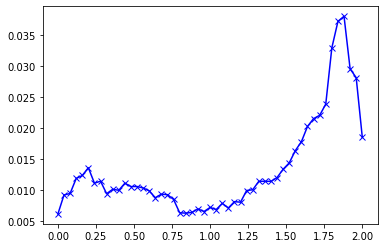

Noise correlation


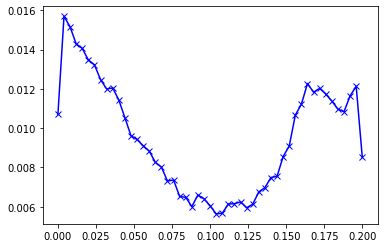

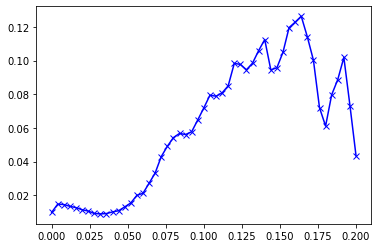

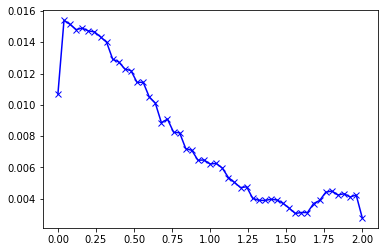

In [55]:
print("Stimulus correlation")
errors = np.convolve(np.array(g2_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g2_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g1_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g0_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g0_errors)[:, 0], errors, 'bx-')
plt.show()
print("Noise correlation")
errors = np.convolve(np.array(g2_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g2_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g1_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g0_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g0_errors)[:, 0], errors, 'bx-')
plt.show()

In [59]:
single_trial_bin.sum(), pred_single_trial_try.sum()

(12160.0, 12214)

In [132]:
recorded_noise_corr = noise_corr2(single_trial_bin)
deviations = []
for seed in range(100):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
    t_list = [3,3,3,3,2,3]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [1.6, 0., 0., 0.], seed=seed, noise_locs=[3,4,5])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.15, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=seed, thre=1)

    min_error = 10
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr2(single_trial_bin, pred_single_trial)
        if error < min_error:
            min_error = error
            pred_single_trial_try = pred_single_trial
    pred_noise_corr = noise_corr2(pred_single_trial_try)
    deviations.append(pred_noise_corr - recorded_noise_corr)

In [133]:
recorded_noise_corr = noise_corr2(single_trial_bin)
deviations2 = []
for seed in range(100):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
    t_list = [3,3,3,3,2,3]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0., 0., 0.1, 0.], seed=seed, noise_locs=[3,4,5])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.15, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=seed, thre=1)

    min_error = 10
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr2(single_trial_bin, pred_single_trial)
        if error < min_error:
            min_error = error
            pred_single_trial_try = pred_single_trial
    pred_noise_corr = noise_corr2(pred_single_trial_try)
    deviations2.append(pred_noise_corr - recorded_noise_corr)

In [135]:
np.save('./data/deviations2_21-03-15_fc.npy', np.array(deviations2))

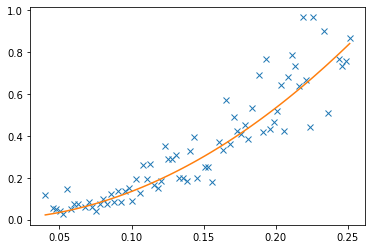

In [67]:
def poly(x,c,d):
        return c*x**2+d*x
    
cell = 5
means = []
rates = []
sigmas = []
thre = 1
pred_single_trial[:, pred<thre] = 0
for rate in np.linspace(0.25, pred_single_trial_pre.mean(0)[:, cell].max(), 100):
    mean, var, _, w = recording.stats_rate(pred_single_trial_pre.mean(0), cell=cell, rate=rate, intv=0.15)
    if var > 0:
        sigmas.append(np.sqrt(var/(w-1)))
        means.append(mean)
        rates.append(rate/100)
sigmas = np.array(sigmas)[~np.isnan(means)]
rates = np.array(rates)[~np.isnan(means)]
means = np.array(means)[~np.isnan(means)]

max_idx = np.where(means >= 0.8*means.max())[0][-1]
min_idx = np.where(rates == rates.min())[0][0]
slope = (means[max_idx] -  means[min_idx]) / (rates[max_idx] -  rates[min_idx])
means_res = means - (rates - rates[min_idx]) * slope - means[min_idx]
valid_idx = np.where(np.abs(means_res/means[max_idx]) < 0.4)

rates = rates[valid_idx]
means = means[valid_idx]
sigmas = sigmas[valid_idx]

para = curve_fit(poly, rates, means, sigma=sigmas)[0]

plt.plot(rates, means, 'x')
plt.plot(rates, [poly(rates[i], *para) for i in range(len(rates))])

In [9]:
for seed in range(100):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
    t_list = [3,3,3,3,2,3]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [1.6, 0., 0., 0.], seed=seed, noise_locs=[3,4,5])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.15, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=seed, thre=1)

    min_error = 10
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr2(single_trial_bin, pred_single_trial)
        if error < min_error:
            min_error = error
    print(seed, min_error)

0 0.0044284515308832175
1 0.004863788473664627
2 0.004296489561256895
3 0.004800930241917301
4 0.0045292397168104105
5 0.00410399967579126
6 0.004039380470572987
7 0.003901307400073967
8 0.0051570266710642566
9 0.003776595681227795
10 0.004057951837702237
11 0.004770549381210503
12 0.005439603228136541
13 0.003732481716425571
14 0.004484950706548022
15 0.004197235436361928
16 0.00520750080625659
17 0.004548505055165796
18 0.004984388818001535
19 0.0035630503691965795
20 0.0040968713250211656
21 0.004468878458782053
22 0.002767950134741946
23 0.0036134961461988324
24 0.00354288436965944
25 0.0032723696507306037
26 0.0042805803158072414
27 0.0036942333889049004
28 0.0042609307312127245
29 0.003628027597661969
30 0.0036995785935971413
31 0.0035787410429607585
32 0.0039331520371129105
33 0.004291906426299995
34 0.003729191641549083
35 0.004039910672566404
36 0.002791064993218273
37 0.004851586095247621
38 0.00410326518613032
39 0.004713483857635963
40 0.004085629534047261
41 0.005154837550

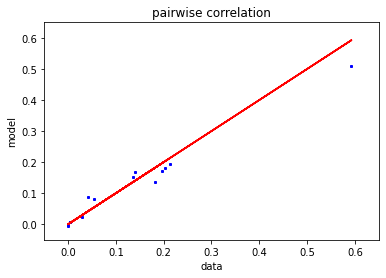

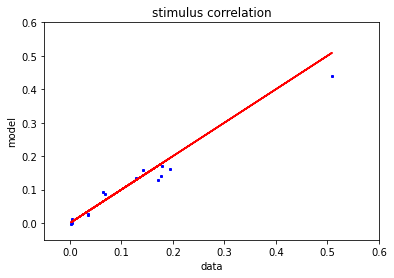

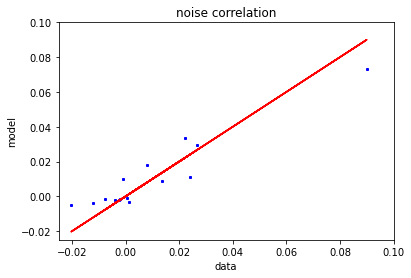

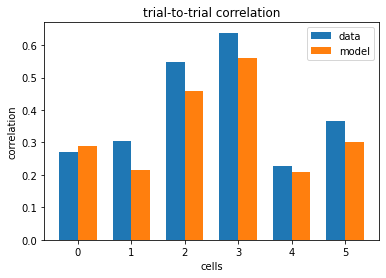

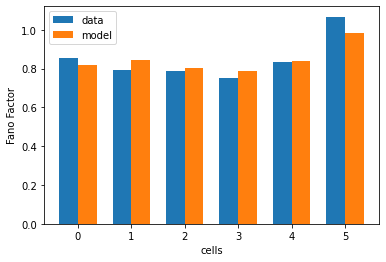

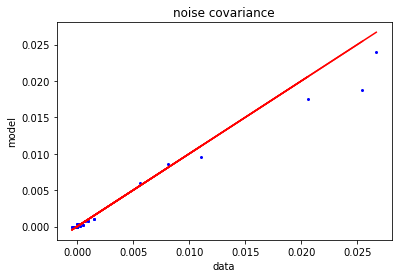

0.0024000475860748863


In [55]:
binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
t_list = [3,3,3,3,2,3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [1.6, 0., 0., 0.], seed=76, noise_locs=[3,4,5])
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.15, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=76, thre=1)

min_error = 10
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
covariance_plot(single_trial_bin, pred_single_trial_try)
print(min_error)

In [29]:
single_trial_bin.sum(), pred_single_trial_try.sum()

(12160.0, 11948)

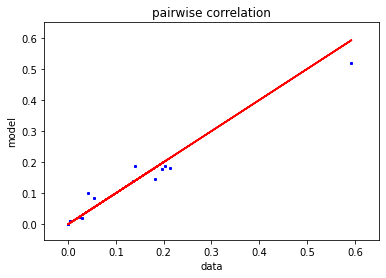

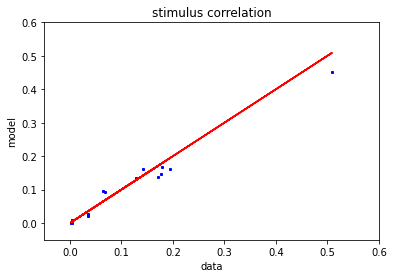

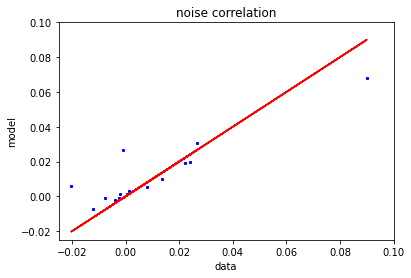

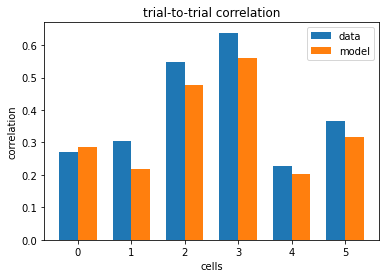

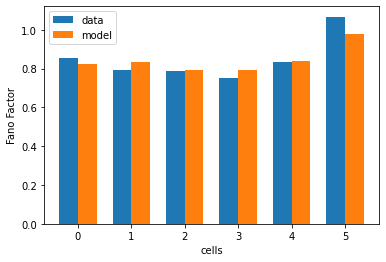

0.004113636792741426


In [64]:
binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
t_list = [3,3,3,3,2,3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [1.6, 0., 0., 0.], seed=76, noise_locs=[3,4,5])
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.3, intv=0.15, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=76, thre=1)

min_error = 10
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

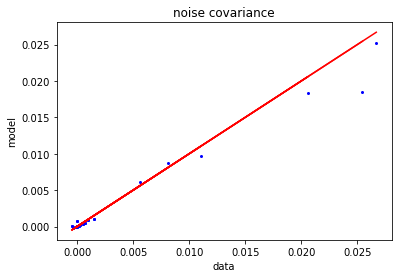

In [68]:
covariance_plot(single_trial_bin, pred_single_trial_try)

In [65]:
(noise_corr2(single_trial_bin) - noise_corr2(pred_single_trial_try))

array([[ 0.01516652,  0.00285112, -0.00175527, -0.00080608,  0.00438163,
        -0.0274401 ],
       [ 0.00285112, -0.08611677, -0.00646903, -0.00122345,  0.00382362,
        -0.00385258],
       [-0.00175527, -0.00646903, -0.07058366,  0.02192934, -0.00184508,
        -0.0260031 ],
       [-0.00080608, -0.00122345,  0.02192934, -0.07935549, -0.00338805,
        -0.00459782],
       [ 0.00438163,  0.00382362, -0.00184508, -0.00338805, -0.02694897,
         0.00262928],
       [-0.0274401 , -0.00385258, -0.0260031 , -0.00459782,  0.00262928,
        -0.04729445]])

In [71]:
noise_cov(single_trial_bin), noise_cov(pred_single_trial_try)

(array([[ 2.54547487e-02,  7.09560810e-04,  2.60867945e-05,
          1.41614027e-05,  5.35897293e-04, -3.13041534e-05],
        [ 7.09560810e-04,  2.06040956e-02, -1.44595375e-04,
         -6.26083068e-05,  2.81737381e-04,  9.36888591e-04],
        [ 2.60867945e-05, -1.44595375e-04,  5.60195278e-03,
          1.49738200e-03, -5.29189260e-05, -4.62854268e-04],
        [ 1.41614027e-05, -6.26083068e-05,  1.49738200e-03,
          8.10330371e-03, -4.09935342e-05, -3.68941808e-04],
        [ 5.35897293e-04,  2.81737381e-04, -5.29189260e-05,
         -4.09935342e-05,  1.10444035e-02,  1.94532953e-04],
        [-3.13041534e-05,  9.36888591e-04, -4.62854268e-04,
         -3.68941808e-04,  1.94532953e-04,  2.66905175e-02]]),
 array([[ 1.85410029e-02,  4.74779660e-04,  5.21735890e-05,
          2.98134794e-05,  3.48817709e-04,  8.23597369e-04],
        [ 4.74779660e-04,  1.83785194e-02, -1.78880877e-05,
         -2.60867945e-05,  1.66955485e-04,  8.95895057e-04],
        [ 5.21735890e-05, -1.7

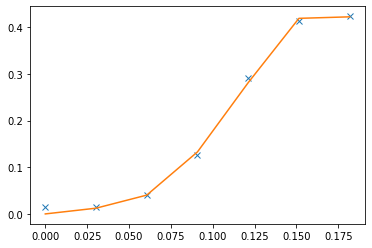

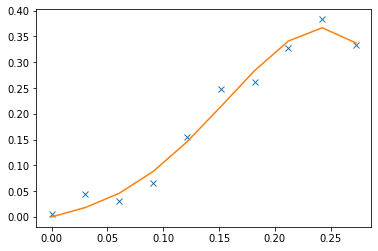

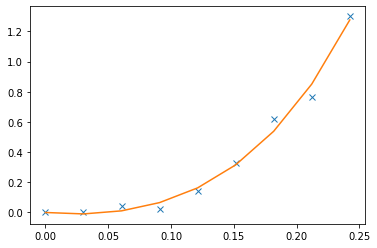

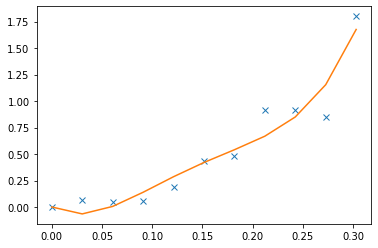

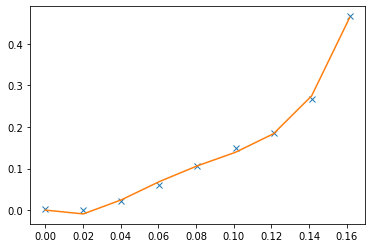

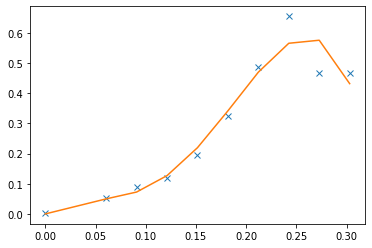

In [42]:
def poly(x,a,b,c,d):
        return a*x**4+b*x**3+c*x**2+d*x
    
for cell in range(6):
    means = []
    rates = []
    for rate in np.linspace(0., 100*t_list[cell], 100):
        mean, var, _, w = recording.stats_rate(pred_single_trial_pre.mean(0), cell=cell, rate=rate, intv=1)
        means.append(mean)
        rates.append(rate/100)
    rates = np.array(rates)[~np.isnan(means)]
    means = np.array(means)[~np.isnan(means)]

    para = curve_fit(poly, rates, means)[0]

    plt.plot(rates, means, 'x')
    plt.plot(rates, [poly(rates[i], *para) for i in range(len(rates))])
    plt.show()

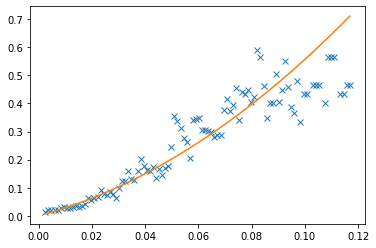

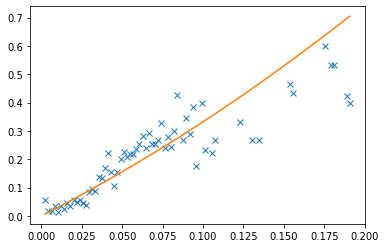

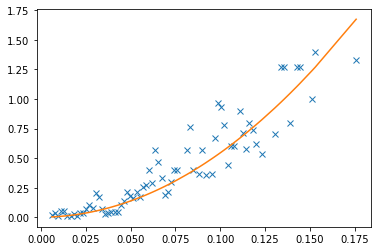

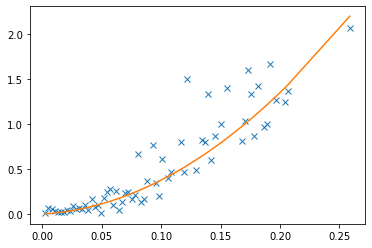

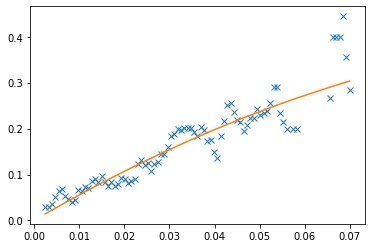

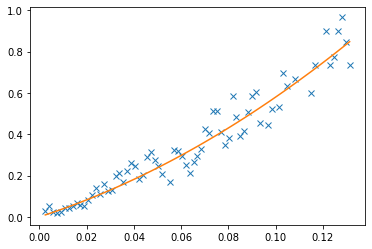

In [72]:
def poly(x,c,d):
        return c*x**2+d*x
    
for cell in range(6):
    means = []
    rates = []
    sigmas = []
    thre = 1
    pred_single_trial_pre[:, pred<thre] = 0
    for rate in np.linspace(0.25, pred_single_trial_pre.mean(0)[:, cell].max(), 100):
        mean, var, _, w = recording.stats_rate(pred_single_trial_pre.mean(0), cell=cell, rate=rate, intv=0.15)
        if var > 0:
            sigmas.append(np.sqrt(var/(w-1)))
            means.append(mean)
            rates.append(rate/100)
    sigmas = np.array(sigmas)[~np.isnan(means)]
    rates = np.array(rates)[~np.isnan(means)]
    means = np.array(means)[~np.isnan(means)]

    max_idx = np.where(means >= 0.8*means.max())[0][-1]
    min_idx = np.where(rates == rates.min())[0][0]
    slope = (means[max_idx] -  means[min_idx]) / (rates[max_idx] -  rates[min_idx])
    means_res = means - (rates - rates[min_idx]) * slope - means[min_idx]
    valid_idx = np.where(np.abs(means_res/means[max_idx]) < 0.3)

    rates = rates[valid_idx]
    means = means[valid_idx]
    sigmas = sigmas[valid_idx]

    para = curve_fit(poly, rates, means, sigma=sigmas)[0]

    plt.plot(rates, means, 'x')
    plt.plot(rates, [poly(rates[i], *para) for i in range(len(rates))])
    plt.show()

In [75]:
g0s = []
g1s = []
g2s = []
stim_errors = []
noise_errors = []
var_errors = []
f = open('./errors_21-03-15.txt', 'r')
for line in f.readlines():
    g0 = round(float(line.split()[0][1:-1]), 3)
    g1 = round(float(line.split()[1][:-1]), 3)
    g2 = round(float(line.split()[2][:-1]), 3)
    stim_error = float(line.split()[3])
    noise_error = float(line.split()[4])
    var_error = float(line.split()[5])
    g0s.append(g0)
    g1s.append(g1)
    g2s.append(g2)
    stim_errors.append(stim_error)
    noise_errors.append(noise_error)
    var_errors.append(var_error)
g0s = np.array(g0s)
g1s = np.array(g1s)
g2s = np.array(g2s)
stim_errors = np.array(stim_errors)
noise_errors = np.array(noise_errors)
var_errors = np.array(var_errors)

In [78]:
g0s[781], g1s[781], g2s[781]

(0.96, 0.025, 0.0)

### BN_CNN

In [5]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_try')
model_func = getattr(models, 'BN_CNN_Stack_Old')
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-3.54_pearson_0.6845.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=500)
test_pc, pred, targ = pearsonr_batch_eval(model, test_data, 6, device)

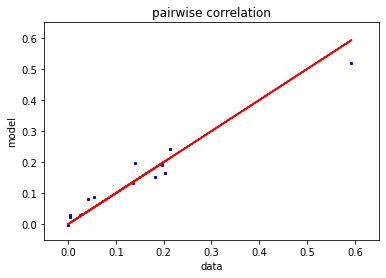

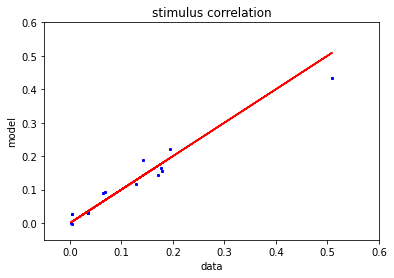

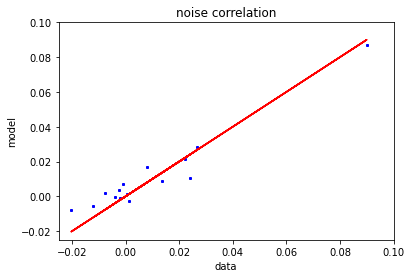

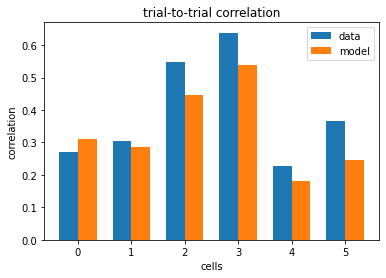

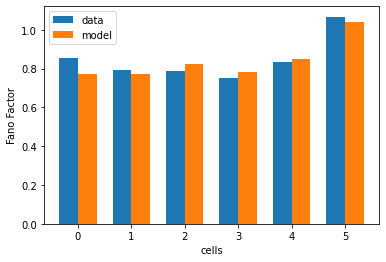

0.001398305463790072


In [5]:
binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
t_list = [3,3,3,3,2,3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0., 0., 0.6, 0.], seed=77)
poly_paras = poly_para_fit(recording, pred_single_trial_pre.copy(), pred, thre=7, threshold=0.4, intv=0.6, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=77, thre=7)

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

In [6]:
path = "./response_dict.npy"
date = "21-03-15"
data = response_dict(path, date, single_trial_bin, pred_single_trial_try)

In [67]:
a = np.load(path, allow_pickle=True)

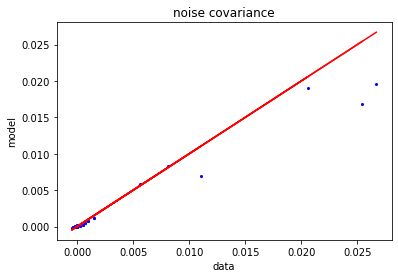

In [198]:
covariance_plot(single_trial_bin, pred_single_trial_try)

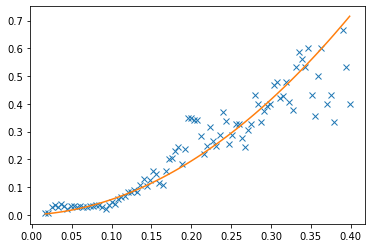

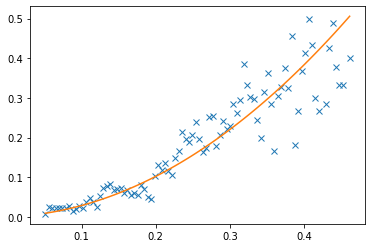

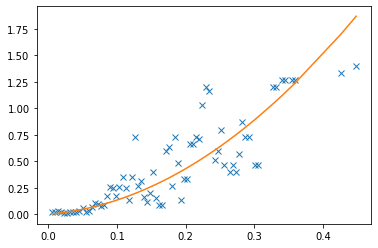

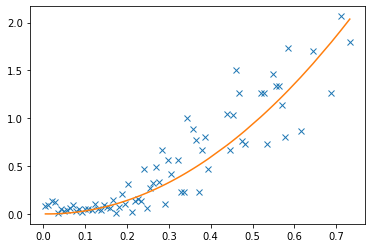

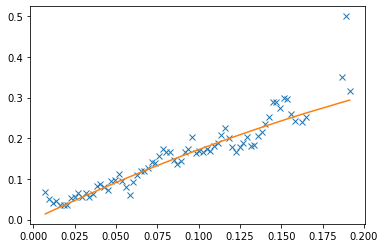

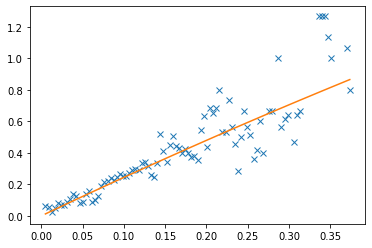

In [184]:
def poly(x,c,d):
        return c*x**2+d*x
    
for cell in range(6):
    means = []
    rates = []
    sigmas = []
    thre = 2.5
    pred_single_trial_pre[:, pred<thre] = 0
    for rate in np.linspace(0.5, pred_single_trial_pre.mean(0)[:, cell].max(), 100):
        mean, var, _, w = recording.stats_rate(pred_single_trial_pre.mean(0), cell=cell, rate=rate, intv=0.4)
        if var > 0:
            sigmas.append(np.sqrt(var/(w-1)))
            means.append(mean)
            rates.append(rate/100)
    sigmas = np.array(sigmas)[~np.isnan(means)]
    rates = np.array(rates)[~np.isnan(means)]
    means = np.array(means)[~np.isnan(means)]

    max_idx = np.where(means >= 0.8*means.max())[0][-1]
    min_idx = np.where(rates == rates.min())[0][0]
    slope = (means[max_idx] -  means[min_idx]) / (rates[max_idx] -  rates[min_idx])
    means_res = means - (rates - rates[min_idx]) * slope - means[min_idx]
    valid_idx = np.where(np.abs(means_res/means[max_idx]) < 0.4)

    rates = rates[valid_idx]
    means = means[valid_idx]
    sigmas = sigmas[valid_idx]

    para = curve_fit(poly, rates, means, sigma=sigmas)[0]

    plt.plot(rates, means, 'x')
    plt.plot(rates, [poly(rates[i], *para) for i in range(len(rates))])
    plt.show()

In [186]:
g2_errors = []
g1_errors = []
g0_errors = []

t_list = [3,3,3,3,2,3]

for g2 in np.linspace(0.3, 1, 51):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0, 0, g2, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=7, threshold=0.4, intv=0.6, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, thre=7)
    
    min_error = 10
    
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial)
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g2_errors.append((g2, min_error_stim, min_error))

for g1 in np.linspace(0., 1, 51):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0, g1, 0, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=7, threshold=0.4, intv=0.6, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, thre=7)
    
    min_error = 10
    
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial)
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g1_errors.append((g1, min_error_stim, min_error))

for g0 in np.linspace(0, 2, 51):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [g0, 0, 0, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=7, threshold=0.4, intv=0.6, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, thre=7)
    
    min_error = 10
    
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial)
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g0_errors.append((g0, min_error_stim, min_error))

Stimulus correlation


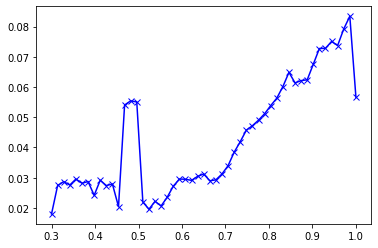

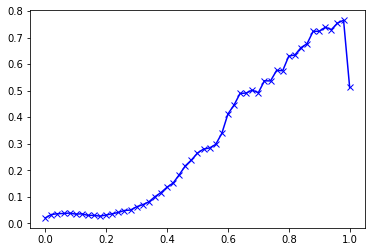

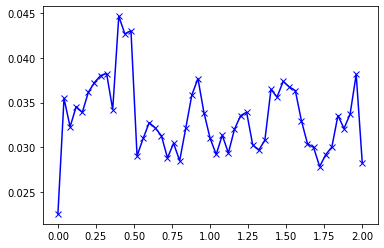

Noise correlation


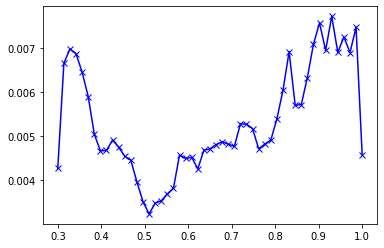

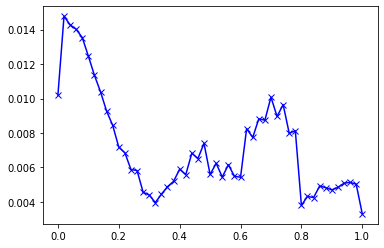

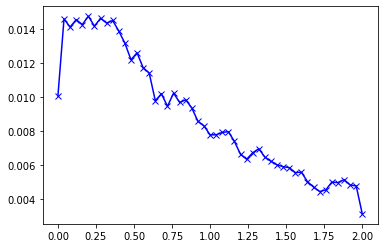

In [187]:
print("Stimulus correlation")
errors = np.convolve(np.array(g2_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g2_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g1_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g0_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g0_errors)[:, 0], errors, 'bx-')
plt.show()
print("Noise correlation")
errors = np.convolve(np.array(g2_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g2_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g1_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g0_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g0_errors)[:, 0], errors, 'bx-')
plt.show()

In [201]:
x = 0.7
print(x/10/3, x/10*9+x/10/3)
print(x/10/3*2, x/10*9+x/10/3*2)

0.02333333333333333 0.6533333333333332
0.04666666666666666 0.6766666666666665


In [7]:
testset = TestDataset(cfg)
X = torch.from_numpy((testset.X.astype('float32') - testset.stats['mean']) / testset.stats['std'])
output = inspect(model, X.to(device), ['bipolar.2', 'amacrine.3'])
s0 = np.abs(X).numpy().mean()
s1 = np.abs(output['bipolar.2']).mean()
s2 = np.abs(output['amacrine.3']).mean()
print((s0, s1, s2))

(0.7589189, 0.07589637, 0.08696955)


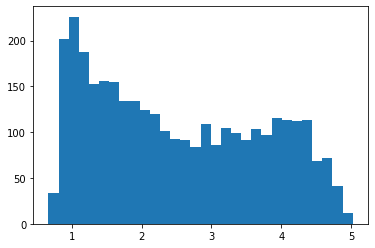

In [209]:
plt.hist(var_errors, bins= 30)
plt.show()

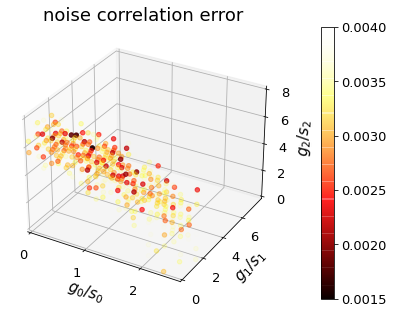

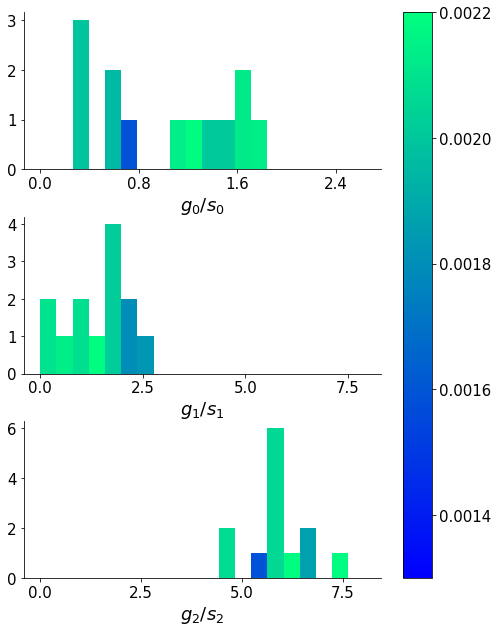

In [38]:
g0s, g1s, g2s, stim_errors, noise_errors, var_errors = read_search_result('./errors_21-03-15.txt')
scatter_plot(g0s, g1s, g2s, stim_errors, noise_errors, var_errors, s0, s1, s2, noise_thre=0.004, stim_thre=0.04, var_thre=2, vmin=0.0015)
marginal_histogram(g0s, g1s, g2s, stim_errors, noise_errors, var_errors, s0, s1, s2, noise_thre=0.0022, stim_thre=0.04, var_thre=2, vmin=0.0013)

In [5]:
from torchdeepretina.utils import compute_sta
from pyret.filtertools import decompose

num_cells = 6

centers = []
for cell in range(num_cells):
    sta = compute_sta(model, 1, "ganglion", cell, verbose=False)
    s, _ = decompose(sta)
    center = np.where(np.abs(s) == np.abs(s).max())
    centers.append((center[0][0], center[1][0]))

def dist(a, b):
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

dists = []
for i in range(num_cells):
    for j in range(i+1, num_cells):
        dists.append(dist(centers[i], centers[j]))
dists = np.array(dists)

In [6]:
print(dists.max(), dists.mean())

6.082762530298219 2.8953652356982276


(-0.025, 0.1)

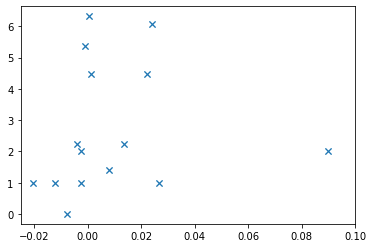

In [30]:
from torchdeepretina.utils import compute_sta
from pyret.filtertools import decompose

num_cells = 6

centers = []
for cell in range(num_cells):
    sta = compute_sta(model, 1, "ganglion", cell, verbose=False)
    s, _ = decompose(sta)
    center = np.where(np.abs(s) == np.abs(s).max())
    centers.append((center[0][0], center[1][0]))

def dist(a, b):
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

dists = np.zeros((num_cells, num_cells))
for i in range(num_cells):
    for j in range(num_cells):
        dists[i, j] = dist(centers[i], centers[j])
        
diagonal_idxs = list(range(0, num_cells*num_cells, num_cells+1))
recorded_noise_corr = noise_corr2(single_trial_bin)
recorded_noise_corr = np.delete(recorded_noise_corr.flatten(), diagonal_idxs)
dists = np.delete(dists.flatten(), diagonal_idxs)

plt.plot(recorded_noise_corr, dists, 'x')
plt.xlim(-0.025, 0.1)

In [11]:
near_idxs = (np.array([1,1,1,2,2,3]), np.array([2,3,5,3,5,5]))

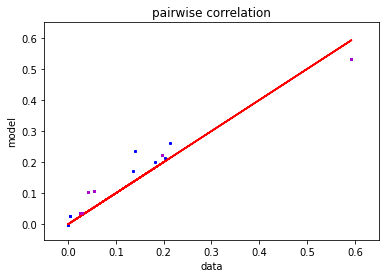

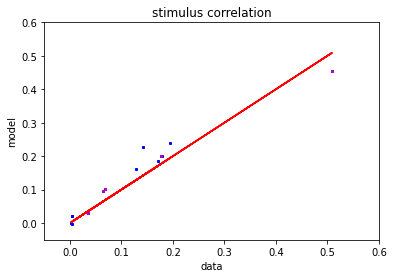

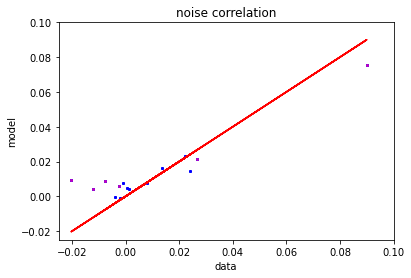

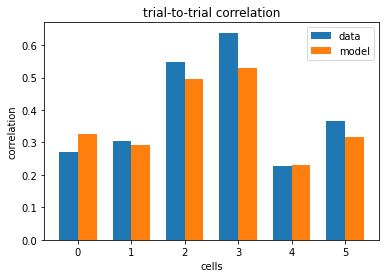

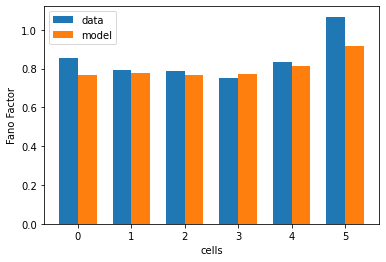

0.0038629440970277397


In [22]:
binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
t_list = [3,3,3,3,2,3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [1.75, 0., 0., 0.])
poly_paras = poly_para_fit(recording, pred_single_trial_pre.copy(), pred, thre=7, threshold=0.4, intv=0.6, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=7)

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
correlation_plot_3(single_trial_bin, pred_single_trial_try, near_idxs=near_idxs)
print(min_error)

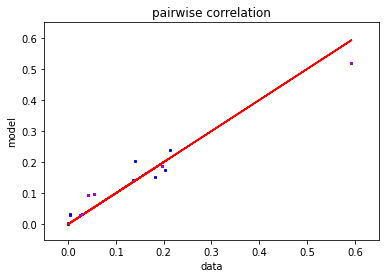

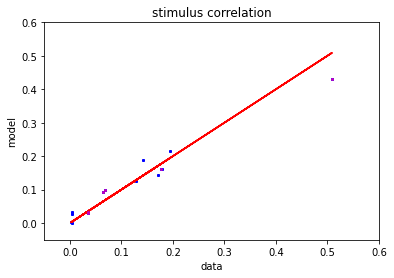

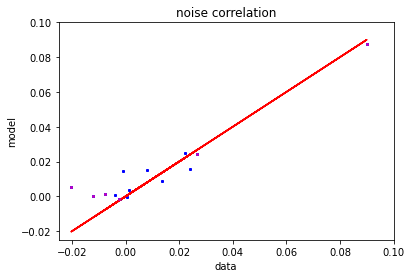

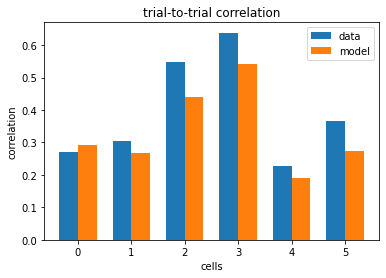

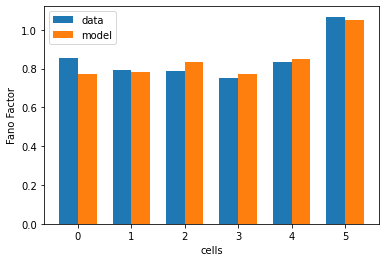

0.002612431023286979


In [20]:
binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
t_list = [3,3,3,3,2,3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0., 0., 0.6, 0.])
poly_paras = poly_para_fit(recording, pred_single_trial_pre.copy(), pred, thre=7, threshold=0.4, intv=0.6, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=7)

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
correlation_plot_3(single_trial_bin, pred_single_trial_try, near_idxs=near_idxs)
print(min_error)

In [120]:
recorded_noise_corr = noise_corr2(single_trial_bin)
deviations = []
for seed in range(100):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
    t_list = [3,3,3,3,2,3]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [1.75, 0., 0., 0.], seed=seed)
    poly_paras = poly_para_fit(recording, pred_single_trial_pre.copy(), pred, thre=7, threshold=0.4, intv=0.6, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=7, seed=seed)

    min_error = 10
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr2(single_trial_bin, pred_single_trial)
        if error < min_error:
            min_error = error
            pred_single_trial_try = pred_single_trial
    pred_noise_corr = noise_corr2(pred_single_trial_try)
    deviations.append(pred_noise_corr - recorded_noise_corr)

In [121]:
recorded_noise_corr = noise_corr2(single_trial_bin)
deviations2 = []
for seed in range(100):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
    t_list = [3,3,3,3,2,3]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0., 0., 0.6, 0.], seed=seed)
    poly_paras = poly_para_fit(recording, pred_single_trial_pre.copy(), pred, thre=7, threshold=0.4, intv=0.6, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=7, seed=seed)

    min_error = 10
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr2(single_trial_bin, pred_single_trial)
        if error < min_error:
            min_error = error
            pred_single_trial_try = pred_single_trial
    pred_noise_corr = noise_corr2(pred_single_trial_try)
    deviations2.append(pred_noise_corr - recorded_noise_corr)

In [125]:
np.save('./data/deviations2_21-03-15.npy', np.array(deviations2))

In [143]:
data = {'dists':dists, 'noise_corr':recorded_noise_corr}
np.save('./data/data_21-03-15.npy', data)

In [112]:
from torchdeepretina.utils import compute_sta
from pyret.filtertools import decompose

num_cells = 6

centers = []
for cell in range(num_cells):
    sta = compute_sta(model, 1, "ganglion", cell, verbose=False)
    s, _ = decompose(sta)
    center = np.where(np.abs(s) == np.abs(s).max())
    centers.append((center[0][0], center[1][0]))

def dist(a, b):
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

dists = np.zeros((num_cells, num_cells))
for i in range(num_cells):
    for j in range(num_cells):
        dists[i, j] = dist(centers[i], centers[j])

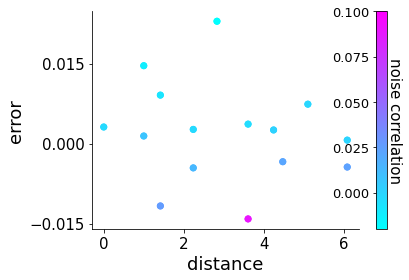

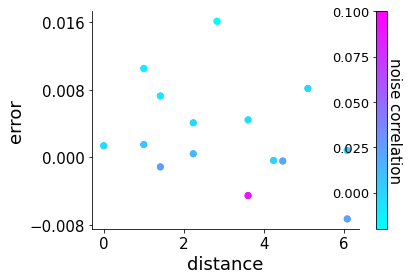

In [136]:
deviation = np.load('./data/deviations0_21-03-15.npy')
recorded_noise_corr = noise_corr2(single_trial_bin)
deviation0 = error_cell_pair_plot(dists, deviation, recorded_noise_corr, num_cells=6, mode='mean', top=5)
deviation = np.load('./data/deviations2_21-03-15.npy')
deviation2 = error_cell_pair_plot(dists, deviation, recorded_noise_corr, num_cells=6, mode='mean', top=5)

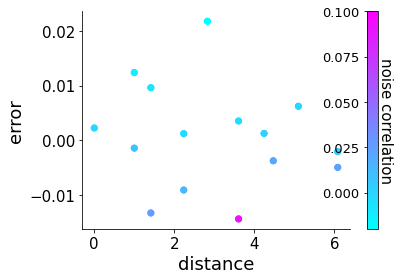

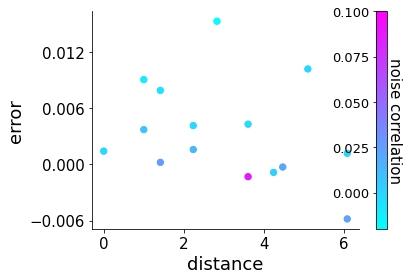

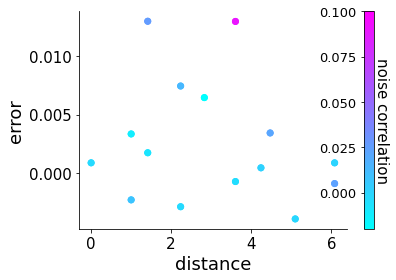

In [140]:
deviation = np.load('./data/deviations0_21-03-15.npy')
recorded_noise_corr = noise_corr2(single_trial_bin)
deviation0 = error_cell_pair_plot(dists, deviation, recorded_noise_corr, num_cells=6, mode='mean', top=3)
deviation = np.load('./data/deviations2_21-03-15.npy')
deviation2 = error_cell_pair_plot(dists, deviation, recorded_noise_corr, num_cells=6, mode='mean', top=3)

noise_corr = np.delete(recorded_noise_corr.flatten(), diagonal_idxs)
rng = [-0.02, 0.1]

fig, ax = plt.subplots()
p = ax.scatter(np.delete(dists.flatten(), diagonal_idxs), np.abs(deviation0) - np.abs(deviation2), c = noise_corr, cmap='cool', vmin=rng[0], vmax=rng[1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(r'distance', fontsize=18)
ax.set_ylabel(r'error', fontsize=18)
cbar = fig.colorbar(p, ax=ax)
cbar.ax.tick_params(labelsize=13)
cbar.ax.locator_params(nbins=5)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.set_ylabel('noise correlation', fontsize=15, labelpad=15, rotation=270)
plt.show()

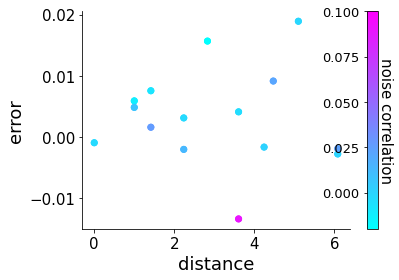

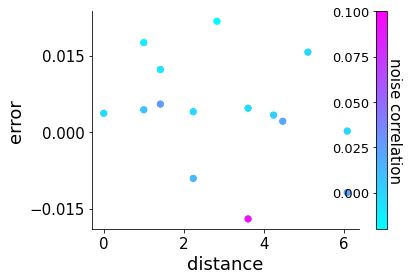

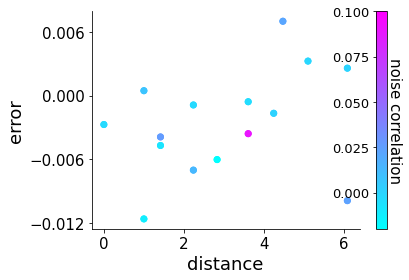

In [141]:
deviation = np.load('./data/deviations0_21-03-15_fc.npy')
recorded_noise_corr = noise_corr2(single_trial_bin)
deviation0 = error_cell_pair_plot(dists, deviation, recorded_noise_corr, num_cells=6, mode='mean', top=3)
deviation = np.load('./data/deviations2_21-03-15_fc.npy')
deviation2 = error_cell_pair_plot(dists, deviation, recorded_noise_corr, num_cells=6, mode='mean', top=3)

noise_corr = np.delete(recorded_noise_corr.flatten(), diagonal_idxs)
rng = [-0.02, 0.1]

fig, ax = plt.subplots()
p = ax.scatter(np.delete(dists.flatten(), diagonal_idxs), np.abs(deviation0) - np.abs(deviation2), c = noise_corr, cmap='cool', vmin=rng[0], vmax=rng[1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(r'distance', fontsize=18)
ax.set_ylabel(r'error', fontsize=18)
cbar = fig.colorbar(p, ax=ax)
cbar.ax.tick_params(labelsize=13)
cbar.ax.locator_params(nbins=5)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.set_ylabel('noise correlation', fontsize=15, labelpad=15, rotation=270)
plt.show()

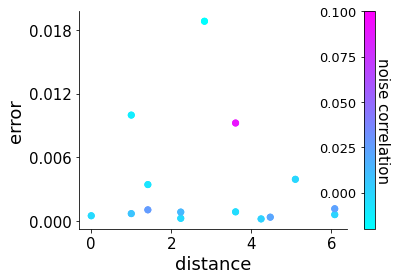

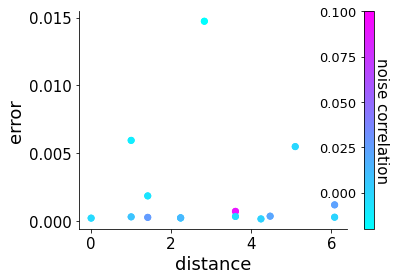

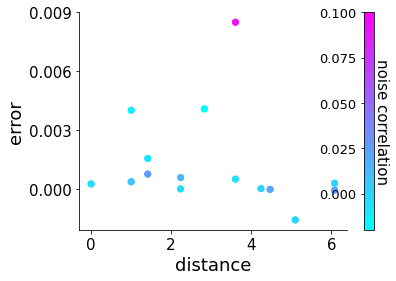

In [114]:
deviation = np.load('./data/deviations0_21-03-15.npy')
recorded_noise_corr = noise_corr2(single_trial_bin)
deviation0 = error_cell_pair_plot(dists, deviation, recorded_noise_corr, num_cells=6, mode='pairwise', top=5)
deviation = np.load('./data/deviations2_21-03-15.npy')
deviation2 = error_cell_pair_plot(dists, deviation, recorded_noise_corr, num_cells=6, mode='pairwise', top=5)

noise_corr = np.delete(recorded_noise_corr.flatten(), diagonal_idxs)
rng = [-0.02, 0.1]

fig, ax = plt.subplots()
p = ax.scatter(np.delete(dists.flatten(), diagonal_idxs), deviation0 - deviation2, c = noise_corr, cmap='cool', vmin=rng[0], vmax=rng[1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(r'distance', fontsize=18)
ax.set_ylabel(r'error', fontsize=18)
cbar = fig.colorbar(p, ax=ax)
cbar.ax.tick_params(labelsize=13)
cbar.ax.locator_params(nbins=5)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.set_ylabel('noise correlation', fontsize=15, labelpad=15, rotation=270)
plt.show()

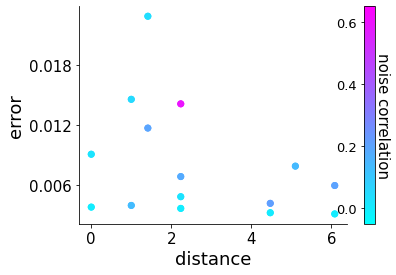

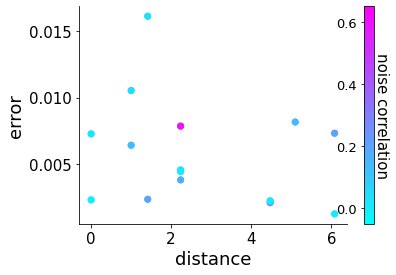

In [103]:
deviation = np.load('./data/deviations0_21-03-15.npy')
recorded_corr = single_trial_corr_matrix(single_trial_bin)
error_cell_pair_plot(dists, deviation, recorded_corr, num_cells=6, mode='mean', top=5, rng=[-0.05, 0.65])
deviation = np.load('./data/deviations2_21-03-15.npy')
error_cell_pair_plot(dists, deviation, recorded_corr, num_cells=6, mode='mean', top=5, rng=[-0.05, 0.65])

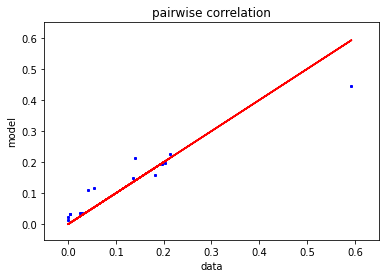

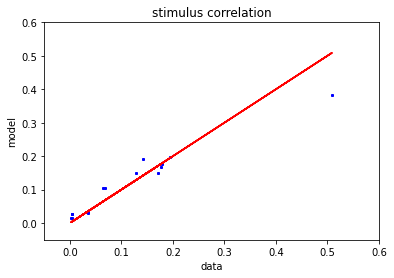

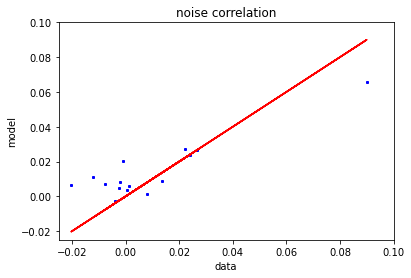

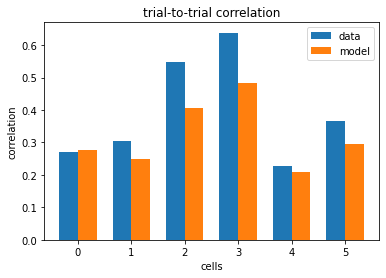

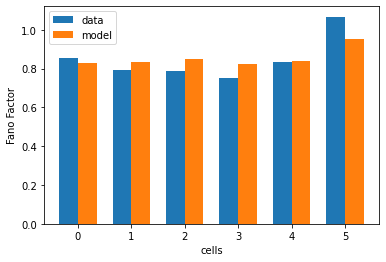

0.005613323142732073


In [128]:
binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
t_list = [3,3,3,3,2,3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [1.8, 0., 0., 0.])
poly_paras = poly_para_fit(recording, pred_single_trial_pre.copy(), pred, thre=2, threshold=0.4, intv=0.6, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=2)

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

In [122]:
g2_errors = []
g1_errors = []
g0_errors = []

t_list = [3,3,3,3,2,3]

for g2 in np.linspace(0.3, 1, 51):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0, 0, g2, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=2, threshold=0.4, intv=0.6, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, thre=2)
    
    min_error = 10
    
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial)
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g2_errors.append((g2, min_error_stim, min_error))

for g1 in np.linspace(0., 1, 51):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0, g1, 0, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=2, threshold=0.4, intv=0.6, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, thre=2)
    
    min_error = 10
    
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial)
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g1_errors.append((g1, min_error_stim, min_error))

for g0 in np.linspace(0, 2, 51):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [g0, 0, 0, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=2, threshold=0.4, intv=0.6, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, thre=2)
    
    min_error = 10
    
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial)
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g0_errors.append((g0, min_error_stim, min_error))

Stimulus correlation


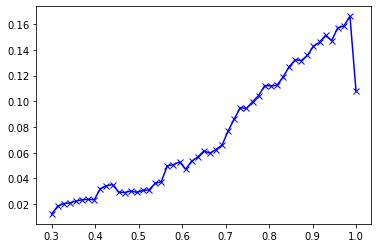

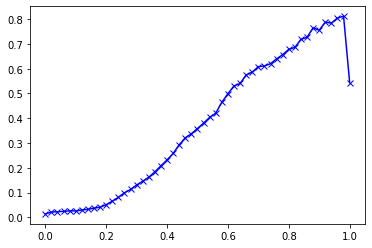

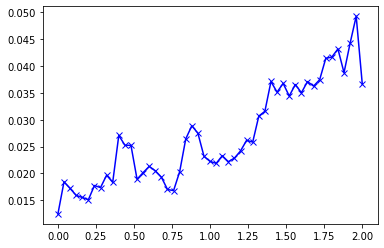

Noise correlation


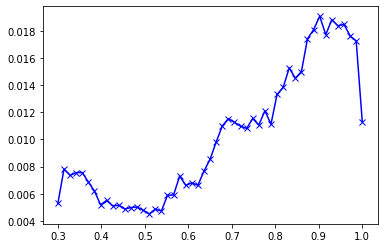

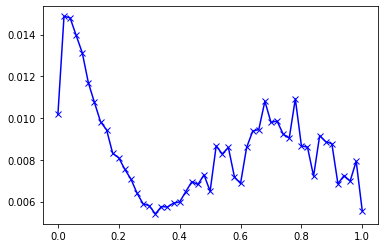

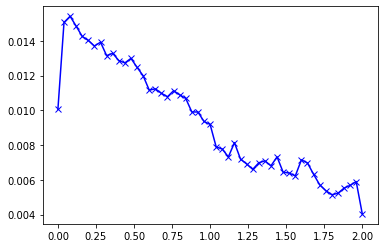

In [123]:
print("Stimulus correlation")
errors = np.convolve(np.array(g2_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g2_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g1_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g0_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g0_errors)[:, 0], errors, 'bx-')
plt.show()
print("Noise correlation")
errors = np.convolve(np.array(g2_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g2_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g1_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g0_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g0_errors)[:, 0], errors, 'bx-')
plt.show()

### NoNorm

In [39]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_nonorm')
model_func = getattr(models, 'BN_CNN_Stack_NoNorm')
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack_NoNorm/epoch_045_loss_-4.00_pearson_0.6683.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=500)
test_pc, pred, targ = pearsonr_batch_eval(model, test_data, 6, device)

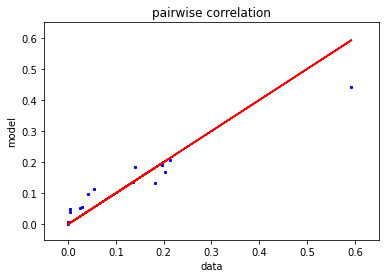

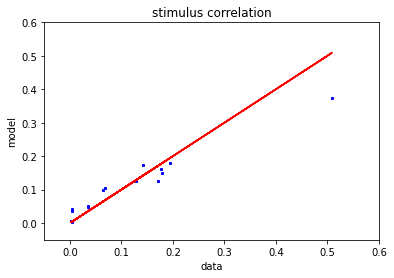

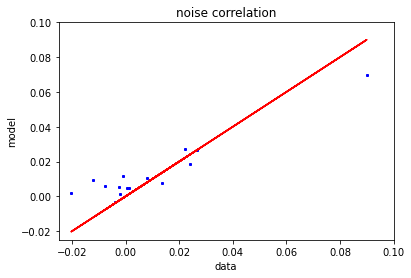

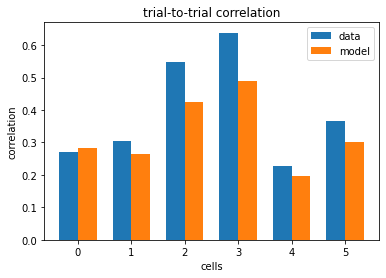

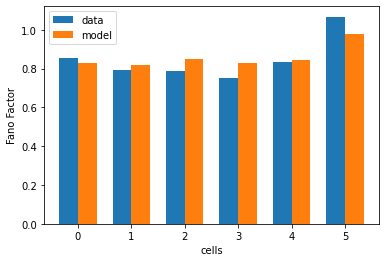

0.003774332506662309


In [51]:
binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
t_list = [3,3,3,3,2,3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0., 0., 10., 0.], noise_locs=[1, 1, 1])
poly_paras = poly_para_fit(recording, pred_single_trial_pre.copy(), pred, thre=7, threshold=0.4, intv=0.6, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=7)

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

In [53]:
for seed in range(100):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
    t_list = [3,3,3,3,2,3]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0., 0., 12., 0.], seed=seed, noise_locs=[1, 1, 1])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre.copy(), pred, thre=7, threshold=0.4, intv=0.6, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=7, seed=seed)

    min_error = 10
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr2(single_trial_bin, pred_single_trial)
        if error < min_error:
            min_error = error
    print(seed, min_error)

0 0.004362859055460688
1 0.004409767140026601
2 0.0028723766357891555
3 0.0031323228230349873
4 0.002134750229835825
5 0.0034171896770915553
6 0.003358317218882933
7 0.002931727545641935
8 0.0022347182305572323
9 0.0026564671599960455


KeyboardInterrupt: 